<a href="https://colab.research.google.com/github/mounsifelatouch/cdd/blob/master/notebooks/1_cdd_ml_part_1_bioactivity_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bioinformatics Project - Computational Drug Discovery [Part 1] Download Bioactivity Data**

**MOUNSIF EL ATOUCH**


In this Jupyter notebook, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 1**, we will be performing Data Collection and Pre-Processing from the ChEMBL Database.


## **Installing libraries**

Install the ChEMBL web service package so that we can retrieve bioactivity data from the ChEMBL Database.

In [1]:
! pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


## **Importing libraries**

In [2]:
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
from chembl_webresource_client.new_client import new_client #provides a client interface to the ChEMBL database of bioactive molecules
import warnings #ignore warnings
warnings.filterwarnings('ignore')
import numpy as np #linear algebra
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## **Search for Target protein**

### **Target search for "urease"**

In [3]:
target = new_client.target
target_query = target.search('urease')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P07374', 'xref_name': None, 'xre...",Canavalia ensiformis,Urease,21.0,False,CHEMBL4161,"[{'accession': 'P07374', 'component_descriptio...",SINGLE PROTEIN,3823
1,[],Bacteria,Bacterial urease,19.0,True,CHEMBL2364683,"[{'accession': 'Q03282', 'component_descriptio...",PROTEIN COMPLEX,2
2,"[{'xref_id': 'Q0PXQ5', 'xref_name': None, 'xre...",Helicobacter pylori,Urease,18.0,False,CHEMBL5325,"[{'accession': 'Q0PXQ5', 'component_descriptio...",SINGLE PROTEIN,210
3,[],Helicobacter pylori (strain ATCC 700392 / 2669...,Urease subunit alpha/Urease subunit beta,18.0,False,CHEMBL3885651,"[{'accession': 'P69996', 'component_descriptio...",PROTEIN COMPLEX,85962


### **Select and retrieve bioactivity data for *Helicobacter pylori urease***

In [4]:
activity = new_client.activity
res1 = activity.filter(target_chembl_id='CHEMBL4161').filter(standard_type="IC50")
d1 = pd.DataFrame.from_dict(res1)

In [5]:
d1.to_csv('d1.csv', index=False)

In [6]:
activity = new_client.activity
res2 = activity.filter(target_chembl_id='CHEMBL2364683').filter(standard_type="IC50")
d2 = pd.DataFrame.from_dict(res2)

In [7]:
d2.to_csv('d2.csv', index=False)

In [8]:
activity = new_client.activity
res3 = activity.filter(target_chembl_id='CHEMBL5325').filter(standard_type="IC50")
d3 = pd.DataFrame.from_dict(res3)

In [9]:
d3.to_csv('d3.csv', index=False)

In [10]:
activity = new_client.activity
res4 = activity.filter(target_chembl_id='CHEMBL3885651').filter(standard_type="IC50")
d4 = pd.DataFrame.from_dict(res4)

In [11]:
d4.to_csv('d4.csv', index=False)

In [12]:
data1 = pd.read_csv('d1.csv')
data2 = pd.read_csv('d2.csv')
data3 = pd.read_csv('d3.csv')
data4 = pd.read_csv('d4.csv')

In [13]:
df1 = pd.concat([data1, data2, data3, data4])

## **Data pre-processing of the bioactivity data**

### **Combine the 3 columns (molecule_chembl_id, canonical_smiles, standard_value = IC50) and bioactivity_class into a DataFrame**

In [14]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df2 = df1[selection]
df2.columns = ['chembl_id', 'canonical_smiles', 'standard_value']

### **Handling missing data**

Save data containing compounds with missing value for the **standard_value**

In [15]:
df2[df2.standard_value.isna()].to_csv('bioactivity_data_raw_with_no_IC50_value.csv', index=False)

If any compounds has missing value for the **standard_value** and **canonical_smiles** column then drop it

In [16]:
df3 = df2[df2.standard_value.notna()]
df4 = df3[df3.canonical_smiles.notna()]

### **Remove duplicates**
Drop duplicate molecules based on their canonical SMILES representation

In [17]:
df5 = df4.drop_duplicates(['canonical_smiles'])

Saves dataframe to CSV file

In [18]:
df5.to_csv('bioactivity_data_preprocessed.csv', index=False)

### **Labeling compounds as either being active or inactive**
The bioactivity data is in the IC50 unit. Compounds having values of <= 1000 nM will be considered to be **active** while those >= 10000 nM will be considered to be **inactive**.

In [19]:
df6 = pd.read_csv('bioactivity_data_preprocessed.csv')

In [20]:
bioactivity_threshold = []
for i in df6.standard_value:
  if float(i) <= 1000:
    bioactivity_threshold.append("active")
  elif float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  else:
    bioactivity_threshold.append("intermidiate")

In [21]:
bioactivity_class = pd.Series(bioactivity_threshold, name='activity')
df7 = pd.concat([df6, bioactivity_class], axis=1)

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

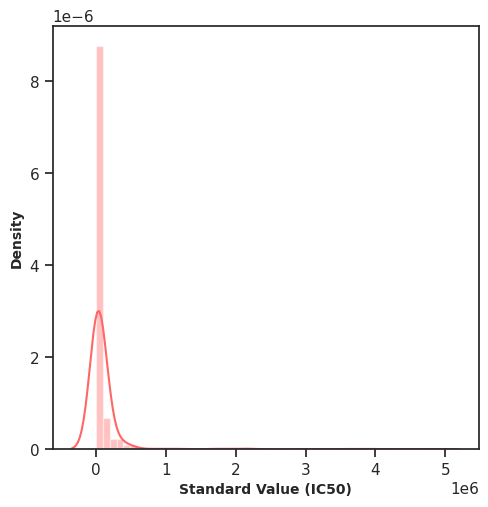

In [22]:
plt.figure(figsize=(5.5, 5.5))
color = (1, 0.4, 0.4)
sns.distplot(df7['standard_value'], color=color, label='IC50')

plt.xlabel('Standard Value (IC50)', fontsize=10, fontweight='bold')
plt.ylabel('Density', fontsize=10, fontweight='bold')

plt.savefig('plot_IC50_distribution.png', dpi=300)

In [23]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        molar = i*(10**-9) #converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', 1)

    return x

In [24]:
df_final = pIC50(df7)

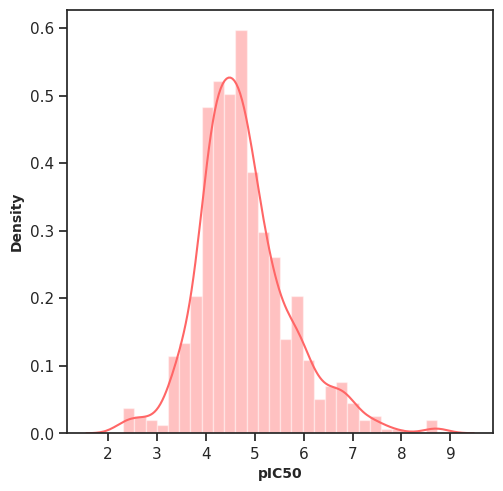

In [25]:
plt.figure(figsize=(5.5, 5.5))
color = (1, 0.4, 0.4)
sns.distplot(df_final['pIC50'], color=color, label='pIC50')

plt.xlabel('pIC50', fontsize=10, fontweight='bold')
plt.ylabel('Density', fontsize=10, fontweight='bold')

plt.savefig('plot_pIC50_distribution.png', dpi=300)

Saves dataframe to CSV file

In [26]:
df_final = df_final[df_final['activity'] != 'intermidiate']

In [27]:
df_final.to_csv('bioactivity_data_curated.csv', index=False)

In [30]:
df_final.activity.value_counts()

inactive    466
active       67
Name: activity, dtype: int64

In [31]:
! zip lab1.zip *

  adding: bioactivity_data_curated.csv (deflated 76%)
  adding: bioactivity_data_preprocessed.csv (deflated 79%)
  adding: bioactivity_data_raw_with_no_IC50_value.csv (deflated 80%)
  adding: d1.csv (deflated 91%)
  adding: d2.csv (deflated 88%)
  adding: d3.csv (deflated 87%)
  adding: d4.csv (deflated 94%)
  adding: plot_IC50_distribution.png (deflated 26%)
  adding: plot_pIC50_distribution.png (deflated 17%)
  adding: sample_data/ (stored 0%)




---

